# Dataset Generation

### Segmenting Dataset into separate folders based on label

In [2]:
import os
import shutil
import pandas as pd

os.chdir("../shivanshu")

csv_file_path = "HAM10000_metadata.csv"
image_folder_path = "HAM10000_images"
output_folder_path = "data"

if os.path.exists(image_folder_path) == False:
    print(f"{image_folder_path} not found! Assuming segmentation is already completed!")
else:
    data = pd.read_csv(csv_file_path)
    os.makedirs(output_folder_path, exist_ok=True)
    for index, row in data.iterrows():
        image_id = row["image_id"]
        label = row["dx"]
        src_image_path = os.path.join(image_folder_path, f"{image_id}.jpg")
        label_folder_path = os.path.join(output_folder_path, label)
        os.makedirs(label_folder_path, exist_ok=True)
        dest_image_path = os.path.join(label_folder_path, f"{image_id}.jpg")
        if os.path.exists(src_image_path):
            shutil.move(src_image_path, dest_image_path)
        else:
            print(f"Warning: Image {image_id}.jpg not found in {image_folder_path}")
    print("Dataset segmentation complete!")

HAM10000_images not found! Assuming segmentation is already completed!


In [3]:
import os
from collections import defaultdict

dataset_path = "data"
class_counts = defaultdict(int)

for class_dir in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_path):
        class_counts[class_dir] = len(os.listdir(class_path))

print("Class Counts:", class_counts)
max_count = max(class_counts.values())
print("Max Count:", max_count)

Class Counts: defaultdict(<class 'int'>, {'nv': 6705, 'vasc': 6705, 'mel': 6705, 'df': 6705, 'akiec': 6705, 'bcc': 6705, 'bkl': 6705})
Max Count: 6705


### Creating augmented dataset and balancing

In [4]:
import os
from tqdm import tqdm
import random
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

def create_augmented_image(image_path: str, output_file_path):
    if(image_path.split(os.path.sep)[-1].find('aug_') != -1):
        raise Exception(f"Tried to augment a file which is already augmented! {image_path=}")
    try:
        image = Image.open(image_path)

        # Brightness adjustment
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))

        # Contrast adjustment
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))

        # Rotation
        image = image.rotate(random.randint(-15, 15))

        # Flip (horizontal and vertical)
        if random.choice([True, False]):
            image = ImageOps.mirror(image)  # Horizontal flip
        if random.choice([True, False]):
            image = ImageOps.flip(image)  # Vertical flip

        # Color adjustment
        enhancer = ImageEnhance.Color(image)
        image = enhancer.enhance(random.uniform(0.8, 1.2))

        # Sharpness adjustment
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(random.uniform(0.5, 2.0))

        # Gaussian Blur (simulating slight blur effect)
        if random.random() < 0.3:  # 30% chance to apply blur
            image = image.filter(ImageFilter.GaussianBlur(random.uniform(0.1, 2.0)))

        # Crop and resize (random crop of 80-100% of the image)
        width, height = image.size
        crop_factor = random.uniform(0.8, 1.0)
        left = random.randint(0, int((1 - crop_factor) * width))
        upper = random.randint(0, int((1 - crop_factor) * height))
        right = left + int(crop_factor * width)
        lower = upper + int(crop_factor * height)
        image = image.crop((left, upper, right, lower)).resize((width, height), Image.ANTIALIAS)

        # Save augmented image
        image.save(output_file_path)
    except Exception as e:
        print(f"Error augmenting image {image_path}: {e}")

def balance_class(label):
    class_path = os.path.join(dataset_path, label)
    files = os.listdir(class_path)
    count = max_count - class_counts[label]
    i = 0
    print(f"Total {count} images to be made for class {label}, so a total of {count/len(files)} copies of each file")
    while(count>0):
        print(f"Creating {min(count, len(files))} new images for class {label} out of {count} remaining images")
        for file in tqdm(files,total=min(count, len(files))):
            count-=1
            if(count<0):
                break
            input_file_path = os.path.join(class_path, file)
            output_file_path = os.path.join(dataset_path, label, f"{file.split('.')[0]}_aug{i}.{file.split('.')[-1]}")
            create_augmented_image(input_file_path, output_file_path)
        i += 1
    class_counts[label] = max_count


def balance_dataset():
    for label in class_counts.keys():
        print(f"Balancing {label}")
        class_path = os.path.join(dataset_path, label)
        class_counts[label] = len(os.listdir(class_path))
        if(class_counts[label] < max_count):
            balance_class(label)
        print(f"Balanced {label} ✅")

# Tests for above functions
# create_augmented_image('data/akiec/ISIC_0024329.jpg', "test.jpg")
balance_dataset()

Balancing nv
Balanced nv ✅
Balancing vasc
Balanced vasc ✅
Balancing mel
Balanced mel ✅
Balancing df
Balanced df ✅
Balancing akiec
Balanced akiec ✅
Balancing bcc
Balanced bcc ✅
Balancing bkl
Balanced bkl ✅


# Training

### Loading Dataset

2024-12-01 21:55:14.162711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 39900 images belonging to 7 classes.
Found 7035 images belonging to 7 classes.
Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
7
(32, 7)
Inputs shape: (32, 300, 300, 3), dtype: float32
Labels shape: (32, 7), dtype: float32


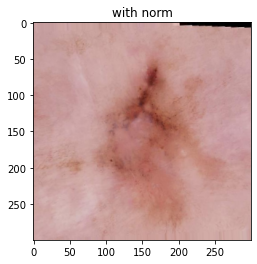

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import os


def load_ham10000_data(data_dir, img_size=(300, 300)):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.15,
        horizontal_flip=True,
        zoom_range=0.2,
        rotation_range=10,
    )

    train_data = datagen.flow_from_directory(
        directory=data_dir,
        target_size=img_size,
        batch_size=32,
        class_mode="categorical",
        subset="training",
    )

    val_data = datagen.flow_from_directory(
        directory=data_dir,
        target_size=img_size,
        batch_size=32,
        class_mode="categorical",
        subset="validation",
    )

    return train_data, val_data


data_dir = "data"
img_size = (300, 300)
train_data, val_data = load_ham10000_data(data_dir, img_size)


class_indices = train_data.class_indices
classes = list(class_indices.keys())
labels = np.array([train_data.classes])

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels.flatten()
)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")
print(train_data.class_indices)
print(train_data.num_classes)
for data, labels in train_data:
    print(labels.shape)
    break

batch = next(iter(train_data))

print(f"Inputs shape: {batch[0].shape}, dtype: {batch[0].dtype}")
print(f"Labels shape: {batch[1].shape}, dtype: {batch[1].dtype}")

import matplotlib.pyplot as plt

plt.title("with norm")
plt.imshow(batch[0][0] / 255)
plt.show()

### Accuracy Logger

In [6]:
import json
import os
from tensorflow.keras.callbacks import Callback

class AccuracyLoggerCallback(Callback):
    def __init__(self, json_file_path):
        super().__init__()
        self.json_file_path = json_file_path
        self.epoch_data = {"accuracy": [], "val_accuracy": []}

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")

        self.epoch_data["accuracy"].append(accuracy)
        self.epoch_data["val_accuracy"].append(val_accuracy)

        with open(self.json_file_path, "w") as f:
            json.dump(self.epoch_data, f, indent=4)

### Checkpoint Callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "efficientnet_model_checkpoints/model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    save_weights_only=False,
    verbose=1,
)

### Building Model

In [8]:
def build_efficientnet_model(input_shape=(300, 300, 3), num_classes=7):
    base_model = EfficientNetB3(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_efficientnet_model(input_shape=(300, 300, 3), num_classes=len(classes))
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,794,294 (41.18 MB)

 Trainable params: 10,759 (42.03 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

### Training the model

In [ ]:
if os.path.exists('efficientnet.h5'):
    print("model file already exists. Loading the model from it...")
    model = tf.keras.models.load_model("efficientnet.h5")
else:
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        class_weight=class_weights,
        callbacks=[early_stopping, AccuracyLoggerCallback("epoch_accuracy.json"), checkpoint_callback]
    )
    loss, accuracy = model.evaluate(val_data)
    print(f"Validation Accuracy: {accuracy:.2f}")
    model.save("efficientnet.h5")

# Fine-tuning

In [10]:
if os.path.exists("efficientnet_finetuned.keras"):
    print("Finetuned Model file already exists. Loading the model from it...")
    model = tf.keras.models.load_model("efficientnet_finetuned.keras")

for layer in model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, AccuracyLoggerCallback("finetuned_epoch_accuracy.json"), checkpoint_callback]
)

loss, accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {accuracy:.2f}")

model.save("efficientnet_finetuned.keras")

Epoch 1/10


# Metrics

In [ ]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('Accuracy 0.84/efficientnet_finetuned.keras')

pred_probs = model.predict(val_data)

pred_labels = np.argmax(pred_probs, axis=1)

true_labels = val_data.classes

balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
print(f"Balanced Multiclass Accuracy: {balanced_acc:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot(cmap='Blues')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels, pred_labels))

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

true_labels_binarized = label_binarize(
    true_labels, classes=np.arange(len(val_data.class_indices))
)
n_classes = true_labels_binarized.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(true_labels_binarized[:, i], pred_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower left')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()